In [1]:
import os
import cv2
import yaml
import torch
import random

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from torch.utils.data import DataLoader

In [2]:
os.sys.path.append('/workspace/nem/NEM/train/')

In [3]:
from train.data import *
from train.utils import *
from train.model import NeuralNetwork
from train.train import train

### focus on kurtosis features

(979, 1469, 3)


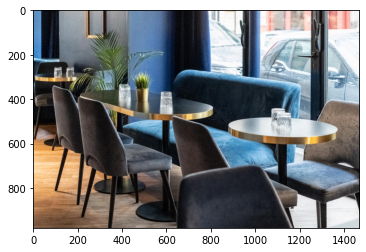

In [9]:
folder_path = "/workspace/datasets/noise_dataset/images/"
image_folder = os.listdir(folder_path)

i = random.randint(0, len(image_folder))

image_name = image_folder[i]
image_path = os.path.join(folder_path, image_name)

image = plt.imread(image_path)
print(image.shape)
plt.imshow(image)

In [10]:
features = compute_kurtosis(discrete_cosine_transform(image, block_size=8))

In [16]:
features

array([[ -0.86233095,  15.05357425,  17.30438094,  25.64314381,
         29.56363295,  24.10518117,  21.91786806,  20.28217465,
         19.66442689,  17.80253493,  23.79679448,  18.85351262,
         14.256879  ,  14.81208743,  14.59245411,  16.70986585,
         23.36220004,  20.45118908,  32.1737119 ,  13.5002817 ,
          8.16917683,  16.20150846,  28.04790678,  11.98100832,
         25.42959466,  14.74775962,  11.46019991,   7.31007581,
          9.62904301,  57.83279281,  43.64323267,  17.96398007,
         18.92847337,  11.30745444,   6.7138244 ,  12.16528382,
         19.8782567 , 100.        , 100.        ,  48.12338426,
         18.75477139,   6.72514511,  10.85282128,  15.17762871,
         57.96633953, 100.        , 100.        , 100.        ,
         13.6780441 ,  16.9446098 ,  35.81261854,  81.34160379,
        100.        , 100.        , 100.        , 100.        ,
         36.81719673,  70.66199007, 100.        , 100.        ,
        100.        , 100.        , 100.

In [15]:
features[features > 100] = 100

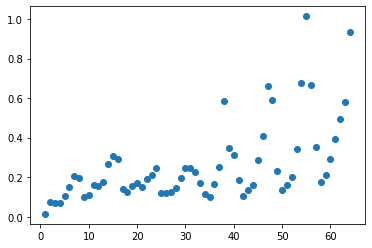

In [6]:
x = np.arange(1, 65, 1)

plt.scatter(x, features)

### testing model

In [39]:
model = NeuralNetwork(input_size=64)

In [43]:
ckpt_path = "/workspace/nem/NEM/checkpoints/nem_training_01.ckpt"

ckpt = torch.load(ckpt_path)

In [44]:
model.load_state_dict(ckpt, strict=True)

<All keys matched successfully>

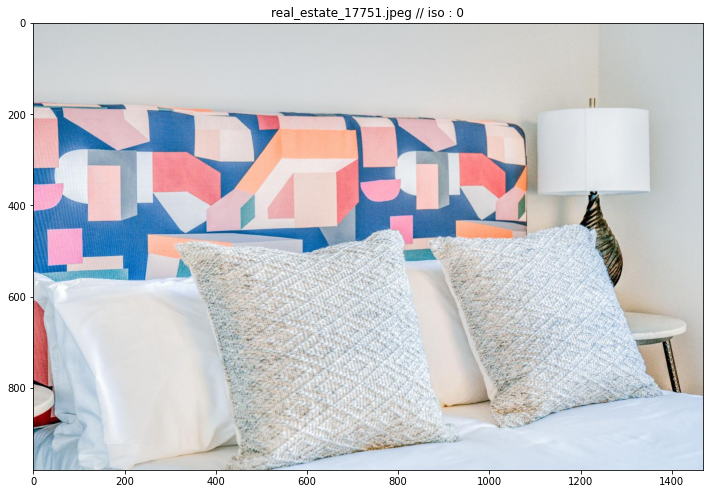

tensor([[64.1221]], grad_fn=<ReluBackward0>)


In [103]:
input_dir = "/workspace/datasets/noise_dataset/images/"
input_names = os.listdir(input_dir)

i = np.random.randint(0, len(input_names))

# load random input image
image_name = input_names[i]
image_path = os.path.join(input_dir, image_name)
image = plt.imread(image_path)

# image degradation
noise_image, noise_type, noise_value = create_noise(image)

# display the image
plt.figure(figsize=(12,9))
plt.imshow(noise_image)
plt.title(f"{image_name} // {noise_type} : {noise_value}")
plt.show()

# feature extraction
image = central_crop(image, 1200, 1600)
dct = discrete_cosine_transform(noise_image, block_size=8)
features = torch.tensor(compute_kurtosis(dct))

prediction = model(features.float())

print(prediction)


### piecewise funtion for noise_value - noise_score mapping

In [105]:
def linear_function(point1:tuple, point2:tuple, x):

    x_range = point2[0] - point1[0]
    y_range = point2[1] - point1[1]

    slope = y_range / x_range
    intercept = point1[1] - point1[0]*slope

    return(x*slope + intercept)


def f(x, values):
    if x is None: 
        value = values[0] 
        values.pop(0)
        return value
    else: return x


def create_noise_score(noise_type:str, noise_value:float):

    if noise_type == 'iso':

        value_list = [(0,15), (15,30), (30,50), (50,300), (300,500), (500,1000)]
        score_list = [100, 95, 90, None , 5, 0]

    elif noise_type == 'gaussian':

        value_list = [(0,15), (15,30), (30,50), (50,75), (75,100), (100,300) ,(300,500), (500,1500), (1500,2000)]
        score_list = [100, 95, 90, 85, 80, None, 15, None, 0]

    points = []
    
    for (idx, v) in enumerate(score_list):

        if v is None: 
            
            y1 = score_list[idx-1]
            y2 = score_list[idx+1]
            x1 = value_list[idx][0]
            x2 = value_list[idx][1]
            
            points.insert(len(points), (x1,y1))
            points.insert(len(points), (x2,y2))
    
    values = []
    
    for i in range(len(points)//2):
        
        values.append(linear_function(points[2*i], points[2*i + 1], noise_value))
    
    score_list = list(map(lambda x: f(x, values), score_list))

    return int(np.piecewise(noise_value, [j[0]<= noise_value < j[1] for j in value_list], score_list))


In [119]:
x_iso = [0,15,30,50,100,300,500,1000]
y_iso = [100,100, 90, 85, 10, 5, 0]

In [115]:
# if require polynomial fitting
z_iso = np.polyfit(x_iso, y_iso, 7)
p_iso = np.poly1d(z_iso)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [107]:
create_noise_score(noise_type='gaussian', noise_value=200)

47

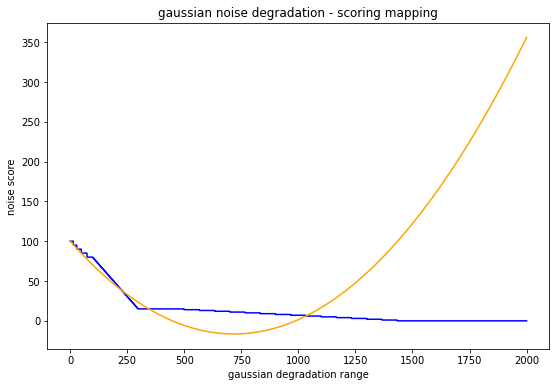

In [109]:
x = np.linspace(0,2000,2000)
y = [create_noise_score(noise_type='gaussian', noise_value=j) for j in x]

plt.figure(figsize=(9,6))
plt.plot(x, y, color='b', label="piecewiese")
plt.title("gaussian noise degradation - scoring mapping")
plt.xlabel("gaussian degradation range")
plt.ylabel("noise score")
plt.show()

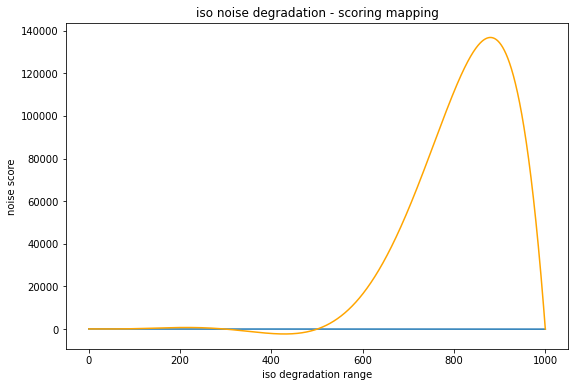

In [116]:
x = np.linspace(0,1000, 10000)
y = [create_noise_score(noise_type='iso', noise_value=j) for j in x]

plt.figure(figsize=(9,6))
plt.plot(x, y)
plt.title("iso noise degradation - scoring mapping")
plt.xlabel("iso degradation range")
plt.ylabel("noise score")
plt.show()

### sigmoid mapping interpolation

In [29]:
def sigmoid(x, x0, k, b):
    y = b - b/(1 + np.exp(-k*(x-x0)))
    return y

#### iso noise

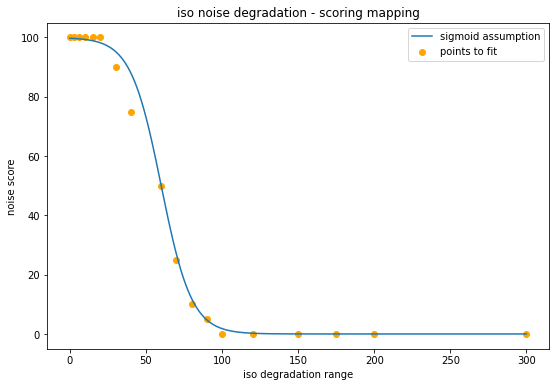

In [36]:
k = 0.1
x0 = 60

b = 100
x = np.linspace(0, 300, 10000)
y = [sigmoid(j, x0, k, b) for j in x]
#y_ = [sigmoid(j, popt[0], popt[1], popt[2]) for j in x]

x_iso = [0,  3,  6,  10, 15, 20,  30, 40, 60, 70, 80, 90, 100, 120, 150, 175, 200, 300]
y_iso = [100,100,100,100,100,100, 90, 75, 50, 25, 10, 5,  0,   0,   0,   0,   0,   0]

plt.figure(figsize=(9,6))
plt.plot(x, y, label="sigmoid assumption")
plt.scatter(x_iso, y_iso, color='orange', label="points to fit")
plt.title("iso noise degradation - scoring mapping")
plt.xlabel("iso degradation range")
plt.ylabel("noise score")
plt.legend()
plt.show()

In [31]:
# fitting the sigmoid to data

p0 = [100, 0.1, 60]

popt_iso, pcov_iso = curve_fit(sigmoid, x_iso, y_iso,p0, method='dogbox')

print(popt_iso)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

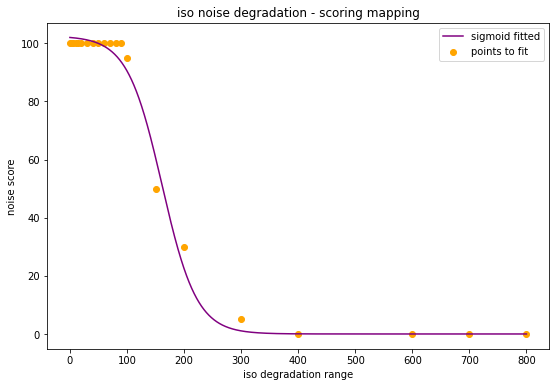

In [233]:
x = np.linspace(0,800, 10000)
y_ = [sigmoid(j, popt_iso[0], popt_iso[1], popt_iso[2]) for j in x]

plt.figure(figsize=(9,6))
plt.plot(x, y_, color='purple', label="sigmoid fitted")
plt.scatter(x_iso, y_iso, color='orange', label="points to fit")
plt.title("iso noise degradation - scoring mapping")
plt.xlabel("iso degradation range")
plt.ylabel("noise score")
plt.legend()
plt.show()

#### gaussian noise

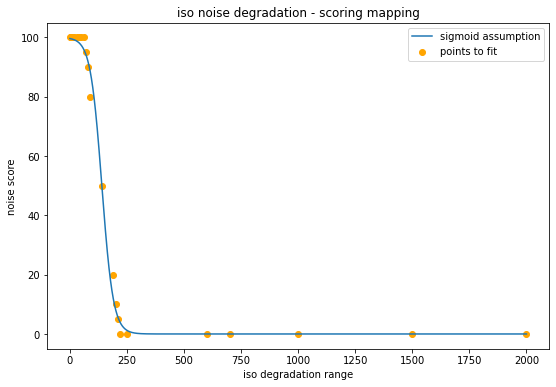

In [43]:
k = 0.04
x0 = 140

b = 100
x = np.linspace(0,2000, 10000)
y = [sigmoid(j, x0, k, b) for j in x]

x_gaussian = [0,  3,  6,  10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 140, 190, 200, 210, 220, 250, 600, 700, 1000, 1500, 2000]
y_gaussian = [100,100,100,100,100,100,100,100,100,100,95, 90, 80, 50,  20,  10,  5,   0,   0,   0,   0,   0,    0,    0]

plt.figure(figsize=(9,6))
plt.plot(x, y, label="sigmoid assumption")
plt.scatter(x_gaussian, y_gaussian, color='orange', label="points to fit")
plt.title("iso noise degradation - scoring mapping")
plt.xlabel("iso degradation range")
plt.ylabel("noise score")
plt.legend()
plt.show()

In [235]:
p0 = [170, 0.032, 100]

popt_gaussian, pcov_gaussian = curve_fit(sigmoid, x_gaussian, y_gaussian,p0, method='dogbox')

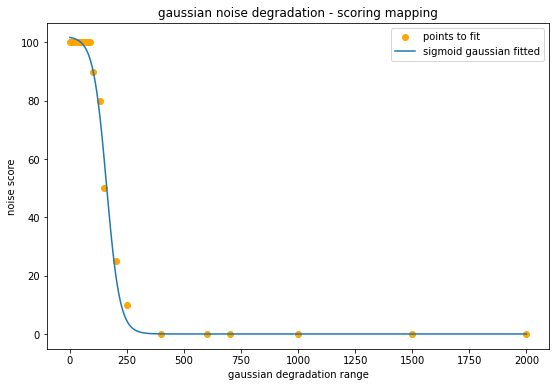

In [238]:
x = np.linspace(0,2000, 10000)
y = [sigmoid(j, popt_gaussian[0], popt_gaussian[1], popt_gaussian[2]) for j in x]

plt.figure(figsize=(9,6))
plt.scatter(x_gaussian, y_gaussian, color='orange', label="points to fit")
plt.plot(x, y, label="sigmoid gaussian fitted")
plt.title("gaussian noise degradation - scoring mapping")
plt.xlabel("gaussian degradation range")
plt.ylabel("noise score")
plt.legend()
plt.show()

In [240]:
print(popt_gaussian)

[1.60363107e+02 3.44928215e-02 1.02079186e+02]


### testing DatasetNoise

In [4]:
csv_path = "/workspace/datasets/noise_dataset/noise_dataset.csv"

paths_train, paths_test, paths_val = train_test_split(csv_path)

In [5]:
dataset = DatasetNoise(train_path=paths_train)

In [6]:
dataset.__getitem__(156)

(array([[-1.9136    ,  1.83733689,  0.36384198, -0.58138505, -0.51768229,
          0.0754938 ,  0.1979375 ,  0.57467738,  0.02451017, -0.46309808,
          0.15743968, -0.38514162, -0.34719517,  0.36054808, -0.00573347,
         -0.14315501, -0.07161981, -0.35442718,  0.05434298, -0.23855451,
         -0.56381566,  0.65288818, -0.40697412,  0.36661485, -0.15146243,
          0.36409831, -0.00415001,  0.59862691,  0.49942794, -0.03736253,
          0.55382277,  0.4547359 , -0.12423774, -0.69218058, -0.23396137,
         -0.62177836,  0.15004509,  0.70561194, -0.13749797,  0.16830744,
          0.30706105,  0.6384171 ,  0.12238428, -0.33443931, -0.25457994,
         -0.50040448, -0.50184672, -0.3405098 , -0.06942347, -0.70064945,
          0.10259221, -0.29515961, -0.78945975, -0.33299228,  1.19156577,
          0.80969061, -0.08139552, -0.28301708,  0.30591239, -0.41772798,
         -0.41599193, -0.15863729, -0.29168749, -0.67398494,  0.09626228]]),
 'iso',
 0)

In [7]:
dataloader = DataLoader(dataset=dataset, batch_size=20, shuffle=True)

In [ ]:
for (a, b, c) in dataloader: print(a, b, c)

### testing on-the-fly noise generation

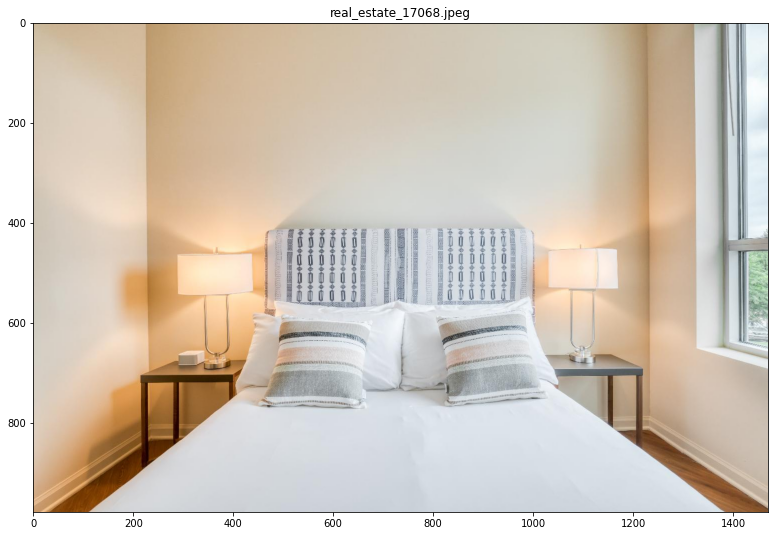

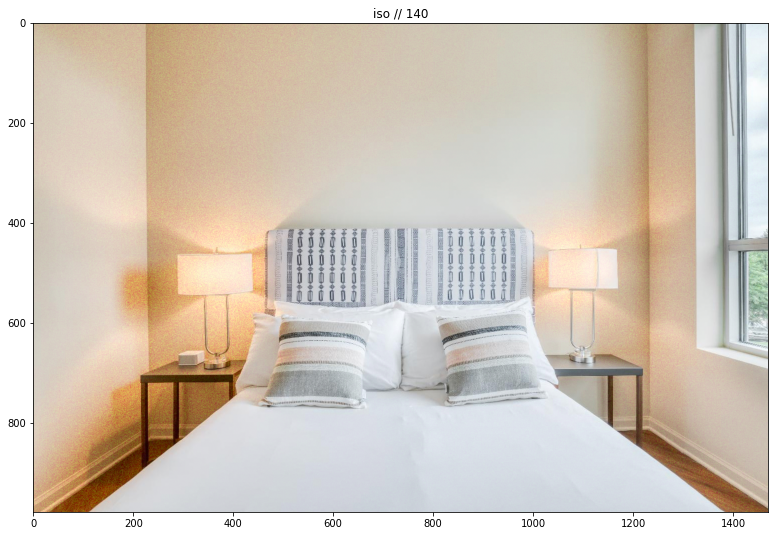

In [10]:
# reading a random image
i = random.randint(0,20400)

image_folder = "/workspace/datasets/noise_dataset/images/"
image_name = os.listdir(image_folder)[i]
image_path = os.path.join(image_folder, image_name)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,9))
plt.imshow(image)
plt.title(f"{image_name}")
plt.show()

image_noise, noise_type, noise_value = create_noise(image)

plt.figure(figsize=(16,9))
plt.imshow(image_noise)
plt.title(f"{noise_type} // {noise_value}")
plt.show()

In [ ]:
csv_path = "/workspace/datasets/dar_research_dataset/data/data.csv"

shooting_train = [40995928, 7046230, 63086130]

df = pd.read_csv(csv_path, delimiter='|')

shooting_ids = list(df['shooting_id'].unique())

for bla in df[df['shooting_id'] == shooting_ids[0]]['img_id']: print(bla)

#list(df[df['shooting_id'].isin(shooting_train)]['image_path'])

#### creating fake csv file

In [4]:
df = pd.DataFrame(columns=['images_paths', 'noise_types', 'noise_values'])

noise_possible = ['GaussianNoise', 'ISONoise']
folder_path = "/workspace/datasets/nem_sample_dataset/ground_truth/"

In [5]:
images_names = os.listdir(folder_path)
images_paths = [folder_path + v for v in images_names]

noise_values = np.random.randint(0,100, 100)
noise_types = np.array([noise_possible[i] for i in np.random.randint(0,2, 100)])

df = pd.DataFrame({'images_paths':images_paths, 'noise_values':noise_values, 'noise_types':noise_types})

In [11]:
df.to_csv('/workspace/nem/NEM/sample.csv')

#### test NEM code

In [13]:
dataset = DatasetNoise(csv_path ='/workspace/datasets/noise_dataset/noise_dataset.csv')

In [ ]:
dataloader = DataLoader(dataset=dataset, batch_size=200, shuffle=True)

for (x, _, y) in dataloader: print(len(y))

In [15]:
model = NeuralNetwork(input_size=64)

In [16]:
train(model=model, dataloader=dataloader, n_epochs=3, learning_rate=0.001)

[TRAINING] Starting epoch 0/3


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		iteration 0 epoch 0 MSE : 0.1558
		iteration 1 epoch 0 MSE : 0.1789
		iteration 2 epoch 0 MSE : 0.1759
		iteration 3 epoch 0 MSE : 0.1381
		iteration 4 epoch 0 MSE : 0.1481
		iteration 5 epoch 0 MSE : 0.1559
		iteration 6 epoch 0 MSE : 0.1441
		iteration 7 epoch 0 MSE : 0.1411
		iteration 8 epoch 0 MSE : 0.1371
		iteration 9 epoch 0 MSE : 0.1341
		iteration 10 epoch 0 MSE : 0.1352
		iteration 11 epoch 0 MSE : 0.1305
		iteration 12 epoch 0 MSE : 0.1316


KeyboardInterrupt: 

In [ ]:
for features, _, noise_value in dataloader:
    
    features = features.to(device)
    # noise_type = noise_type.to(device)
    # noise_value = noise_value.to(device)
    
    outputs = model(features.float())
    
    print(outputs)

#### test on a single image

In [12]:
config = load_config('/workspace/nem/NEM/configs/configuration.yaml')

print(config['training']['n_epochs'])

5
